# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 20:43:19--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-07 20:43:19--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.06s   

2023-12-07 20:43:19 (273 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        ymin, xmin, ymax, xmax = None, None, None, None

        xmin = float(member.find("bndbox/xmin").text)
        ymin = float(member.find("bndbox/ymin").text)
        xmax = float(member.find("bndbox/xmax").text)
        ymax = float(member.find("bndbox/ymax").text)
        class_in_dict = class_dict[member.find("name").text]

        res = (xmin, ymin, xmax, ymax, class_in_dict)
        bboxes.append(res)


    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        #print(image)
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        #print(bboxes)
        return self.transform(image=image, bboxes = bboxes)
    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

In [8]:
im = train_ds.class_dict_inv

im

{0: 'snitch', 1: 'quaffle', 2: 'bludger'}

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [9]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * std) + mean
        ax.imshow(img)
        for bbox in bboxes[i]:
            x0, y0, x1, y1 = bbox[:-1]
            # Рисуем прямоугольник на изображении
            ax.add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='r', lw=2))
            # Получаем класс объекта и записываем его над прямоугольником
            class_name = train_ds.class_dict_inv[bbox[-1]]
            ax.text(x0, y0, class_name, color='r', fontsize=8, ha='left', va='bottom') #, backgroundcolor='white'

    fig.tight_layout()

    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

In [ ]:
out = [train_ds[i] for i in range(10)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [11]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape #батч, каналы, высота и ширина

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = w // downsample # размер клетки по X в пикс
        y_cell = h // downsample # размер клетки по Y в пикс
        w_box =  (xmax-xmin) /  w #  ширина бокса отнормированная
        h_box = (ymax-ymin) / h  #высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmin + xmax) / 2 # (координаты центра в исходных координатах)
        cy =  (ymin + ymax) / 2 #
        # точка в терминах клеточек
        cx_idx = cx // downsample # (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = cy // downsample
        # сдвиг от левой нижней границы в терминах клеток
        cx_box = (cx - cx_idx*downsample) / downsample  #(посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx*downsample) / downsample

        target[i, :, cy_idx.to(torch.long), cx_idx.to(torch.long)] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

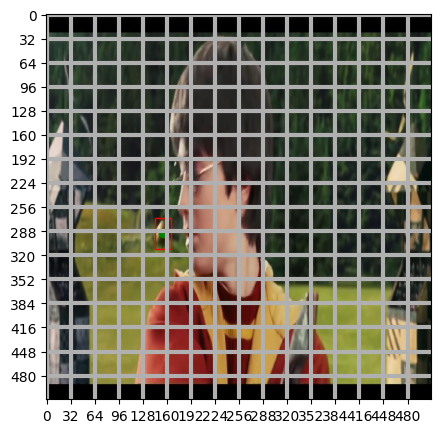

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [13]:
def decode_prediction(pred, upsample=32, threshold=0.1):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    #1. сдвиг cx_ids, сдвиг cy_idx, w_bow, h_box, conf, класс
    bboxes = []
    for i in range(b):  # для каждого изображения в батче
        decoded_boxes = []
        for cy in range(h):  # для каждой клеточки по Y
            for cx in range(w):  # для каждой клеточки по X
                # получаем смещение центра bbox относительно начала клеточки, ширину и высоту, уверенность и классы
                if c == 6:
                  cx_box, cy_box, w_box, h_box, confidence, classes = pred[i, :, cy, cx]
                else:
                  cx_box, cy_box, w_box, h_box, confidence  = pred[i, 0:5, cy, cx]
                  classes = pred[i, 5:, cy, cx]
                if confidence > threshold:  # если уверенность выше порога
                    # пересчитываем координаты и размеры bbox
                    xmin = float(((cx_box * upsample + cx*upsample) - w_box * img_w / 2).item())
                    xmax = float(((cx_box * upsample + cx*upsample ) + w_box * img_w / 2).item())
                    ymin = float(((cy_box * upsample + cy*upsample)  - h_box * img_h / 2).item())
                    ymax = float(((cy_box * upsample + cy*upsample) + h_box * img_h / 2).item())

                   # decoded_boxes.append(xmin, ymin, xmax,ymax, classes.index(max(classes))) # находим индекс класса с наибольшей вероятностью
                    if c > 6:
                      decoded_boxes.append((xmin, ymin, xmax,ymax, int(torch.argmax(classes))))
                    else:
                      decoded_boxes.append((xmin, ymin, xmax,ymax, int(classes)))
        if len(decoded_boxes)!=0:
              bboxes.append(decoded_boxes)

    return bboxes  # возвращаем список прямоугольников с координатами, классами и уверенностью

In [14]:
#Проверка decode_perdiction (снимите # чтобы увидеть)

#batch1 = next(iter(loader))
#visualize(batch1["image"], decode_prediction(batch1["target"]))

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [15]:
C = 3 # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_blocks = nn.Sequential(*list(model.children())[:8])
        self.conv1 = nn.Conv2d(2048, 512, 3, 1, 1)
        self.conv2 = nn.Conv2d(512, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 8, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()

        self.batch_norm1 = nn.BatchNorm2d(512)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = self.resnet_blocks(img)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.sigmoid(x)

        return x

In [16]:
#model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
#print(model.children())

In [17]:
#child_counter = 0
#for child in model.children():
#    print(" child", child_counter, "is -")
#    print(child)
#    child_counter += 1

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [18]:
import torch.nn.functional as F
def special_loss(pred, target, check=False, C=3):
    b, c, h, w = pred.shape
    mask = target [:,4,:,:].unsqueeze(1) > 0 # Создаем маску, которая говорит о наличии детектируемого объекта
    mask_n = target [:,4,:,:].unsqueeze(1) < 1 #маска, чтобы учитывался 0 класс в таргете
    ### YOUR CODE HERE ###
    l = nn.BCELoss()
    classification_loss = 0
    localization_loss =  F.mse_loss((torch.masked_select(pred[:, 0:2, :, : ], mask)), torch.masked_select(target[:, 0:2, :, : ], mask),  reduction='sum')
    box_loss =  F.mse_loss(torch.sqrt((torch.masked_select(pred[:, 2:4, :, : ], mask))), torch.sqrt(torch.masked_select(target[:, 2:4, :, : ], mask)), reduction='sum')
    a = []
    for i in range (5,8):
      a.append(torch.masked_select(pred[:, i:i+1, :, :],mask))
    nuzh = torch.stack(a, dim = 1)
    classification_loss = F.cross_entropy(nuzh, torch.masked_select(target[:, 5:6, :, : ], mask).long(),reduction='sum')
    confidence_loss = F.binary_cross_entropy(torch.masked_select(pred[:, 4:5, :, : ], mask), torch.masked_select(target[:, 4:5, :, : ], mask), reduction='sum') + 0.1 * F.binary_cross_entropy(torch.masked_select(pred[:, 4:5, :, : ], mask_n), torch.masked_select(target[:, 4:5, :, : ], mask_n), reduction='sum')

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [19]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 6, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [20]:
loader = torch.utils.data.DataLoader(train_ds, 8, collate_fn=collate_fn)

In [21]:
torch.cuda.empty_cache()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 20 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###
        y_pred = model(batch["image"].to(device))
        loss = special_loss(y_pred.to(device), batch["target"].to(device))
        epoch_losses.append(loss.cpu().detach().numpy())
        loss.backward()
        opt.step()  # обновляем параметры сети
        opt.zero_grad()
    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.4MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0 done; Train loss 67.364;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 done; Train loss 21.931;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 done; Train loss 15.712;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 done; Train loss 13.743;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 done; Train loss 10.654;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 done; Train loss 9.123;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 done; Train loss 8.032;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 done; Train loss 7.380;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 done; Train loss 7.746;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 done; Train loss 7.534;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 done; Train loss 7.941;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 done; Train loss 7.693;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 done; Train loss 7.825;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 done; Train loss 7.736;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 done; Train loss 6.646;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 done; Train loss 6.182;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 done; Train loss 6.702;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 done; Train loss 6.215;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 done; Train loss 6.264;


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 done; Train loss 6.634;


Запустим обученный детектор на тестовых изображениях:

In [23]:
test_loader = torch.utils.data.DataLoader(test_ds, 8, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [24]:
# Нужно сделать предсказание и переложить результат на cpu
y_val = model(batch["image"].to(device))
loss = special_loss(y_val.to(device), batch["target"].to(device))

y_cpu = y_val.cpu()

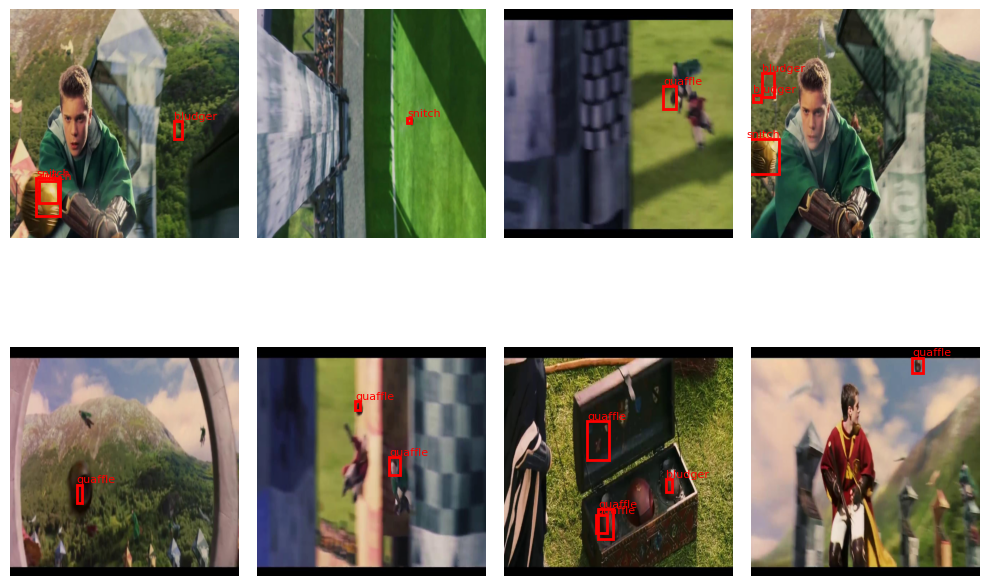

In [25]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
visualize(batch["image"], decode_prediction(y_cpu))

дома рисовал вот так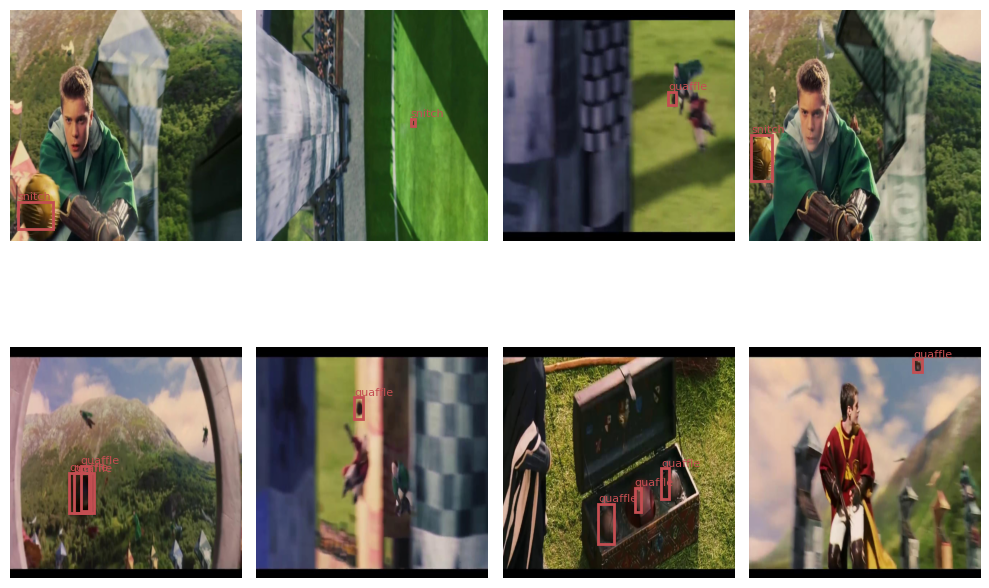



Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [26]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 7.8 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [27]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [28]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    #class_id, center_x, center_y, width, height
    st = []
    for bbox in bboxes:
      x0, y0, x1, y1, class_id = bbox
      center_x = (x0+x1)/(2*w_im)
      center_y = (y0+y1)/(2*h_im)
      width = (x1-x0)/w_im
      height = (y1-y0)/h_im
      st.append("{0} {1} {2} {3} {4}".format(class_id, center_x, center_y, width, height))
    return st

In [29]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [30]:
# Собираем YAML

nc =  3 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ['snitch','quaffle', 'bludger'] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [31]:
from ultralytics import YOLO

# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data='data.yaml',
   imgsz=512,
   epochs=50,
   batch=8,
   name='yolov8n_custom')

100%|██████████| 6.23M/6.23M [00:00<00:00, 314MB/s]

Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, worksp

100%|██████████| 755k/755k [00:00<00:00, 71.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 2105.87it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1161.38it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/yolov8n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         5G      1.505      4.367      1.122         15        512: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         29         35    0.00309      0.718     0.0292      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.01G      1.466       3.27      1.051         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         29         35    0.00365      0.855      0.219      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.02G      1.462      2.904      1.101         13        512: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         29         35      0.544      0.119      0.381      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.02G      1.466      2.799      1.151         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         29         35      0.558      0.428      0.489      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.02G      1.422      2.398      1.068         13        512: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         29         35      0.614      0.582      0.558      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.02G      1.489       2.33      1.176         16        512: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         29         35       0.48      0.573       0.55      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.02G      1.501      2.111      1.135         11        512: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         29         35      0.456      0.639      0.541      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.02G      1.378      2.023      1.098         13        512: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         29         35      0.593      0.742      0.595      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.02G      1.373      1.889      1.107          9        512: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         29         35      0.526      0.573      0.553      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.02G      1.391      1.881      1.081          9        512: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         29         35      0.532      0.429      0.546      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.02G      1.321        1.7      1.055         10        512: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         29         35      0.581       0.65      0.646      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.02G      1.253      1.637      1.061         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         29         35      0.631      0.739       0.72      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.02G      1.266      1.532      1.051         16        512: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         29         35      0.697      0.773      0.741      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.02G       1.25      1.401      1.039         13        512: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         29         35      0.781       0.81      0.814      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.02G      1.224      1.406      1.043         10        512: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         29         35      0.771      0.814      0.816      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.02G      1.199      1.386      1.024         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         29         35      0.924      0.629      0.816      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.02G      1.176      1.308      1.024         11        512: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         29         35      0.743      0.709      0.827      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.02G       1.18      1.249      1.012         11        512: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


                   all         29         35      0.882      0.717      0.833      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.02G        1.2      1.252      1.032         16        512: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         29         35      0.862      0.735       0.83      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.02G       1.16      1.248     0.9888          9        512: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         29         35      0.961      0.692      0.887      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.02G       1.13       1.19      0.974         11        512: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         29         35      0.848      0.621      0.801      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.02G      1.103      1.106      1.001         14        512: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         29         35      0.853      0.816      0.857       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.02G      1.172      1.146      1.077         13        512: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         29         35      0.943       0.75      0.875      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.02G      1.114      1.135      1.015         11        512: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         29         35      0.884      0.725      0.862      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.02G      1.092      1.065     0.9943         17        512: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         29         35      0.857      0.805      0.899      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.02G      1.028     0.9801     0.9747         12        512: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         29         35      0.825      0.853      0.906      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.02G      1.055      1.026     0.9773          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]

                   all         29         35       0.86      0.852      0.863      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.02G      1.017     0.9364     0.9566         10        512: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         29         35      0.886      0.823      0.865      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.02G      1.068      0.959     0.9943          7        512: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         29         35      0.911      0.844       0.92      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.02G      1.048     0.9234     0.9812         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         29         35      0.904      0.864       0.95      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.02G      1.115     0.9816      1.013         12        512: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


                   all         29         35      0.952      0.796      0.922      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.02G      1.019     0.8771     0.9631         11        512: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         29         35      0.986      0.756       0.94      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.02G       1.01     0.8523     0.9462         11        512: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

                   all         29         35      0.943      0.732      0.949      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.02G      1.044     0.8658     0.9597         17        512: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         29         35      0.955      0.705      0.945      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.02G     0.9427     0.7944     0.9226         19        512: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         29         35       0.84      0.863      0.926      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.02G     0.9671     0.8249     0.9724         15        512: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         29         35      0.906      0.869      0.904      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.02G      0.967     0.8404     0.9264         10        512: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         29         35      0.923      0.863      0.913      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.02G     0.9964     0.8103     0.9649          9        512: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         29         35      0.972      0.827       0.93      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.02G     0.9124     0.7927     0.9305         11        512: 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         29         35      0.947      0.859      0.945      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.02G     0.9592     0.7858     0.9365         10        512: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         29         35      0.928      0.869      0.935      0.625


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.02G     0.9521     0.8668     0.9367          8        512: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         29         35      0.867      0.863      0.908      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.02G     0.9815     0.8455     0.9428          7        512: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         29         35      0.857      0.837      0.923      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.02G     0.8961      0.822     0.9282          8        512: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         29         35      0.915      0.833      0.939      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.02G     0.9154     0.7597     0.9092          6        512: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         29         35      0.813      0.874      0.923      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.02G     0.9194     0.7687     0.9086          6        512: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         29         35      0.946      0.828      0.909      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.02G     0.8761     0.7582     0.9213          6        512: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         29         35      0.884      0.839      0.918      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.02G     0.9364     0.7526     0.9307          7        512: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         29         35      0.851      0.843      0.933      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.02G     0.8748     0.7267     0.9101          6        512: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         29         35      0.888      0.869       0.94      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.02G     0.8652     0.7247     0.9029          5        512: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         29         35      0.918      0.827      0.922       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.02G     0.8389     0.7105     0.9073          5        512: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         29         35       0.93       0.83      0.911      0.613



50 epochs completed in 0.105 hours.
Optimizer stripped from runs/detect/yolov8n_custom/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_custom/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_custom/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


                   all         29         35       0.84      0.863      0.925       0.65
                snitch         29          6      0.792          1      0.995      0.697
               quaffle         29         21      0.875      0.857      0.942      0.643
               bludger         29          8      0.854      0.733      0.839      0.611
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/yolov8n_custom


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


0: 512x512 1 quaffle, 1: 512x512 1 bludger, 2: 512x512 1 quaffle, 3: 512x512 1 quaffle, 4: 512x512 1 snitch, 5: 512x512 1 quaffle, 6: 512x512 1 quaffle, 7: 512x512 1 snitch, 8: 512x512 1 quaffle, 9: 512x512 1 quaffle, 61.6ms
Speed: 2.3ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/yolov8n_custom2


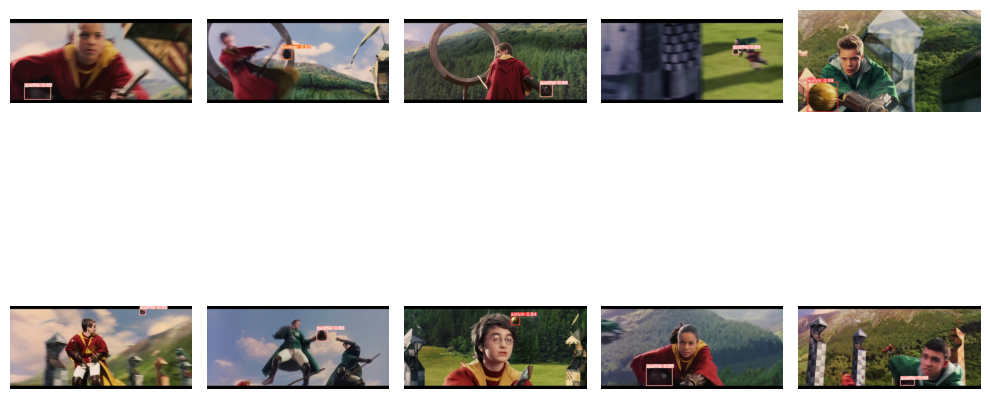

In [32]:
filili = os.listdir("./valid/images")
im = []
for i in range (10):
  im.append(Image.open("./valid/images/{0}".format(filili[i])))
results = model.predict(source=im, save=True)
img = []
for i in range(10):
  img.append(np.asarray(Image.open("runs/detect/" + sorted(os.listdir("runs/detect"))[-1] + "/{0}".format(filili[i])))) #берём картиночки из последней модельки (валидация прям перед ней шла)

fig, axes = plt.subplots(
        2, len(img) // 2 + len(img) % 2, figsize=(10, 8), dpi=100
    )
for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(img):
            break
        ax.imshow(img[i])
fig.tight_layout()
plt.show()

дома йоло выдавал это:
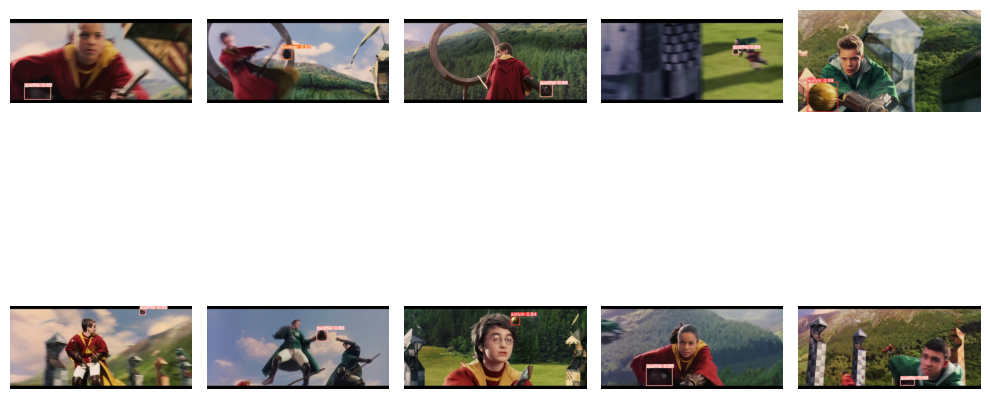